# Validation

In [1]:
import os
import datetime
import itertools
import numpy as np
import pandas as pd
from functools import reduce
from tqdm import tqdm
from pandas import DataFrame

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# # RQ1
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_ebr_results.csv ../data/results/cookpad_repr_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_naive_results.csv ../data/results/cookpad_concat_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_nrmf_simple_query_results.csv ../data/results/cookpad_nrmf_results.csv

# # RQ2
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_nrmf_simple_query_results.csv ../data/results/cookpad_nrmf_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_nrmf_simple_all_results.csv ../data/results/cookpad_nrmf_all_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_fwfm_all_results.csv ../data/results/cookpad_fwfm_all_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_fwfm_query_results.csv ../data/results/cookpad_fwfm_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_nrmf_simple_query_with_1st_results.csv ../data/results/cookpad_nrmf_with_1st_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_fwfm_all_without_1st_results.csv ../data/results/cookpad_fwfm_without_1st_results.csv

# # RQ3
# !gsutil cp -r gs://master-thesis-data/logs/fwfm_selected_results.csv ../data/results/cookpad_fwfm_selected_results.csv

In [3]:
results_dir = '../data/results'
dataset = 'cookpad'

def read_csv(model_name):
    return pd.read_csv(f'{results_dir}/{dataset}_{model_name}_results.csv')

def validate(df, target, models, column_names=None):
    columns = [f'{target} ({model})' for model in models]
    
    if column_names:
        temp = df.rename(columns={a: b for a, b in zip(columns, column_names)})
        temp.boxplot(column=column_names, grid=False)
    else:
        df.boxplot(column=columns, grid=False)
    plt.show()
    
    melted_df = pd.melt(df.reset_index(), id_vars=['index'], value_vars=columns)
    melted_df.columns = ['index', 'treatments', 'value']
    
    model = ols('value ~ C(treatments)', data=melted_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    display(anova_table)
    
    posthoc = pg.pairwise_tukey(
        data=melted_df,
        dv='value',
        between='treatments',
        effsize='cohen',
    )
    pg.print_table(posthoc, floatfmt='.3f')
    
    posthoc = pg.pairwise_ttests(
        data=melted_df,
        dv='value',
        between='treatments',
        parametric=True,
        padjust='bonf',
        effsize='cohen',
    )
    pg.print_table(posthoc, floatfmt='.3f')

In [4]:
dfs = []
for model_name in ['repr', 'concat', 'nrmf', 'nrmf_all', 'fwfm', 'fwfm_all', 'nrmf_with_1st', 'fwfm_without_1st', 'fwfm_selected']:
    df = read_csv(model_name)
    df.rename(columns={'ndcg': f'ndcg ({model_name})', 'val_loss': f'val_loss ({model_name})'}, inplace=True)
    df.drop(columns=['model'], inplace=True)
    dfs.append(df)

df = reduce(lambda a, b: a.merge(b, on='dataset_id'), dfs)
df

,dataset_id,val_loss (repr),ndcg (repr),val_loss (concat),ndcg (concat),val_loss (nrmf),ndcg (nrmf),val_loss (nrmf_all),ndcg (nrmf_all),val_loss (fwfm),ndcg (fwfm),val_loss (fwfm_all),ndcg (fwfm_all),val_loss (nrmf_with_1st),ndcg (nrmf_with_1st),val_loss (fwfm_without_1st),ndcg (fwfm_without_1st),val_loss (fwfm_selected),ndcg (fwfm_selected)
0,0,0.592425,0.6555,0.568476,0.6414,0.567470,0.6535,0.565810,0.6443,0.570853,0.6730,0.566262,0.6665,0.563640,0.6541,0.576397,0.6521,0.563889,0.6757
1,1,0.541445,0.6712,0.563845,0.6349,0.558351,0.6741,0.563187,0.6456,0.566830,0.6778,0.565451,0.6667,0.559328,0.6674,0.570955,0.6541,0.561000,0.6718
2,2,0.590393,0.6528,0.561921,0.6536,0.559969,0.6692,0.563018,0.6485,0.572584,0.6684,0.560419,0.6679,0.562988,0.6526,0.572870,0.6532,0.565381,0.6703
3,3,0.587461,0.6418,0.573145,0.6459,0.575676,0.6556,0.575362,0.6417,0.576719,0.6677,0.570750,0.6668,0.570933,0.6548,0.581089,0.6498,0.573911,0.6596
4,4,0.566202,0.6540,0.580669,0.6465,0.581861,0.6460,0.580989,0.6368,0.581362,0.6633,0.578205,0.6556,0.580544,0.6381,0.591092,0.6378,0.576188,0.6590
5,5,0.587925,0.6383,0.584732,0.6348,0.587914,0.6401,0.583847,0.6383,0.585822,0.6594,0.585042,0.6538,0.582883,0.6435,0.605390,0.6238,0.586629,0.6537
6,6,0.578904,0.6359,0.586983,0.6408,0.593176,0.6356,0.587454,0.6312,0.592691,0.6514,0.588372,0.6480,0.586700,0.6415,0.594370,0.6398,0.589593,0.6469
7,7,0.576391,0.6323,0.582153,0.6422,0.586250,0.6487,0.581852,0.6423,0.582042,0.6665,0.580750,0.6573,0.580507,0.6474,0.589869,0.6437,0.582080,0.6594
8,8,0.597277,0.6480,0.582692,0.6463,0.587188,0.6466,0.583549,0.6370,0.585167,0.6683,0.578455,0.6663,0.577491,0.6523,0.591001,0.6483,0.579912,0.6668
9,9,0.568234,0.6468,0.581183,0.6475,0.583916,0.6484,0.581998,0.6415,0.580093,0.6698,0.577938,0.6570,0.577410,0.6454,0.589464,0.6442,0.576686,0.6676


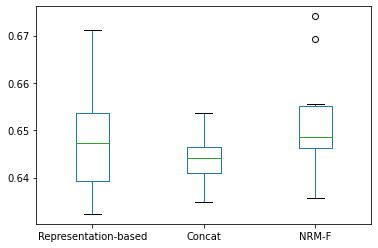

,sum_sq,df,F,PR(>F)
C(treatments),0.000352,2.0,1.708526,0.200138
Residual,0.002781,27.0,NaN,NaN



POST HOC TESTS

A              B              mean(A)    mean(B)    diff     se       T    p-tukey    cohen
-------------  -----------  ---------  ---------  ------  -----  ------  ---------  -------
ndcg (concat)  ndcg (nrmf)      0.643      0.652  -0.008  0.005  -1.848      0.158   -0.827
ndcg (concat)  ndcg (repr)      0.643      0.648  -0.004  0.005  -0.941      0.606   -0.421
ndcg (nrmf)    ndcg (repr)      0.652      0.648   0.004  0.005   0.908      0.625    0.406


POST HOC TESTS

Contrast    A              B              Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust      BF10    cohen
----------  -------------  -------------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ------  -------
treatments  ndcg (repr)    ndcg (concat)  False     True           1.052  18.000  two-sided    0.307     0.920  bonf         0.585    0.470
treatments  ndcg (repr)    ndcg (nrmf)    False     True          -0.785  18.000  two

In [5]:
validate(df, 'ndcg', ['repr', 'concat', 'nrmf'], ['Representation-based', 'Concat', 'NRM-F'])

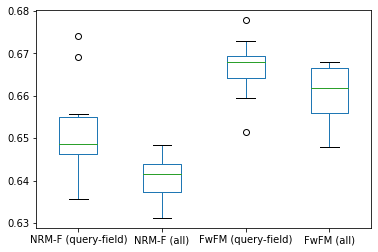

,sum_sq,df,F,PR(>F)
C(treatments),0.003791,3.0,18.545002,1.923882e-07
Residual,0.002453,36.0,NaN,NaN



POST HOC TESTS

A                B                  mean(A)    mean(B)    diff     se      T    p-tukey    cohen
---------------  ---------------  ---------  ---------  ------  -----  -----  ---------  -------
ndcg (fwfm)      ndcg (fwfm_all)      0.667      0.661   0.006  0.004  1.617      0.372    0.723
ndcg (fwfm)      ndcg (nrmf)          0.667      0.652   0.015  0.004  4.003      0.001    1.790
ndcg (fwfm)      ndcg (nrmf_all)      0.667      0.641   0.026  0.004  6.999      0.001    3.130
ndcg (fwfm_all)  ndcg (nrmf)          0.661      0.652   0.009  0.004  2.386      0.085    1.067
ndcg (fwfm_all)  ndcg (nrmf_all)      0.661      0.641   0.020  0.004  5.382      0.001    2.407
ndcg (nrmf)      ndcg (nrmf_all)      0.652      0.641   0.011  0.004  2.996      0.017    1.340


POST HOC TESTS

Contrast    A                B                Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust          BF10    cohen
----------  ---------------  ------------

In [6]:
validate(df, 'ndcg', ['nrmf', 'nrmf_all', 'fwfm', 'fwfm_all'], ['NRM-F (query-field)', 'NRM-F (all)', 'FwFM (query-field)', 'FwFM (all)'])

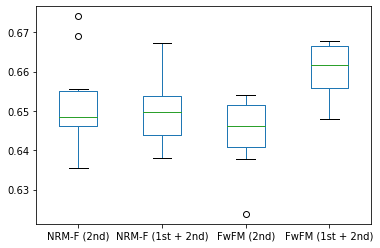

,sum_sq,df,F,PR(>F)
C(treatments),0.001323,3.0,5.038369,0.005117
Residual,0.003151,36.0,NaN,NaN



POST HOC TESTS

A                        B                          mean(A)    mean(B)    diff     se       T    p-tukey    cohen
-----------------------  -----------------------  ---------  ---------  ------  -----  ------  ---------  -------
ndcg (fwfm_all)          ndcg (fwfm_without_1st)      0.661      0.645   0.016  0.004   3.803      0.001    1.701
ndcg (fwfm_all)          ndcg (nrmf)                  0.661      0.652   0.009  0.004   2.106      0.157    0.942
ndcg (fwfm_all)          ndcg (nrmf_with_1st)         0.661      0.650   0.011  0.004   2.601      0.050    1.163
ndcg (fwfm_without_1st)  ndcg (nrmf)                  0.645      0.652  -0.007  0.004  -1.697      0.328   -0.759
ndcg (fwfm_without_1st)  ndcg (nrmf_with_1st)         0.645      0.650  -0.005  0.004  -1.202      0.610   -0.538
ndcg (nrmf)              ndcg (nrmf_with_1st)         0.652      0.650   0.002  0.004   0.495      0.900    0.221


POST HOC TESTS

Contrast    A                        B               

In [7]:
validate(df, 'ndcg', ['nrmf', 'nrmf_with_1st', 'fwfm_without_1st', 'fwfm_all'], ['NRM-F (2nd)', 'NRM-F (1st + 2nd)', 'FwFM (2nd)', 'FwFM (1st + 2nd)'])

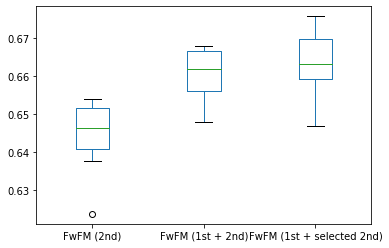

,sum_sq,df,F,PR(>F)
C(treatments),0.001993,2.0,13.955721,0.000069
Residual,0.001928,27.0,NaN,NaN



POST HOC TESTS

A                     B                          mean(A)    mean(B)    diff     se       T    p-tukey    cohen
--------------------  -----------------------  ---------  ---------  ------  -----  ------  ---------  -------
ndcg (fwfm_all)       ndcg (fwfm_selected)         0.661      0.663  -0.002  0.004  -0.659      0.770   -0.295
ndcg (fwfm_all)       ndcg (fwfm_without_1st)      0.661      0.645   0.016  0.004   4.210      0.001    1.883
ndcg (fwfm_selected)  ndcg (fwfm_without_1st)      0.663      0.645   0.018  0.004   4.869      0.001    2.178


POST HOC TESTS

Contrast    A                        B                     Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust      BF10    cohen
----------  -----------------------  --------------------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ------  -------
treatments  ndcg (fwfm_without_1st)  ndcg (fwfm_all)       False     True          -4.332  18.00

In [8]:
validate(df, 'ndcg', ['fwfm_without_1st', 'fwfm_all', 'fwfm_selected'], ['FwFM (2nd)', 'FwFM (1st + 2nd)', 'FwFM (1st + selected 2nd)'])